In [1]:
import numpy as np
import nolds
from matplotlib import pyplot as plt
from numpy import linalg as la
import os
from scipy import stats
from scipy import spatial as sp
from scipy import sparse
from sklearn import linear_model
from scipy import linalg as sla

import lyapynov as le

import pandas as pd
import networkx as nx

import SystemsSolved as s
import Methods as m

import Sparse_Reservoir_Computing as rc

import RecurrencePlotsCode as rp


import multiprocess as mp

In [2]:
mu = 0.00; nu = 0.00
Ry = s.yCoupledRossler(a = 0.2, b = 0.2, c = 5.7, nu1 = nu, mu1 = mu, nu2 = nu, mu2 = mu)
Ry_ts = Ry.solve(t0 = 0, tFinal = 1000, x0_1 = [-1.5, 1.5, 20], x0_2 = [-1, -1, 10], dt = 0.01)

A0 = Ry_ts[0:3, :]; B0 = Ry_ts[3:6, :]


#Parameters
sigma = 0.42777 #Drive
rho = 0.01 #Spectral Radius

r = rc.Reservoir(Nodes = 100, InDim=3, seed=12)
r.Weighted_Erdos_R(SpecRadius=rho, p=0.04)
r.set_rdot(sigma = sigma, gamma = 1)
r.Set_W_in_Matrix() #Error from normalising specral radius

rc1 = rc.RC(SparseReservoir=r, U=A0, dt = 0.01)

rc1.Listening(time=700)
rc1.Training(t0 = 500, tEnd = 700)


c:\Users\jackr\anaconda3\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[1.5179179e-05]
not reaching the requested tolerance 1.4901161193847656e-06.
Use iteration 21 instead with accuracy 
1.5179179046911312e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
c:\Users\jackr\anaconda3\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[1.5179179e-05]
not reaching the requested tolerance 1.4901161193847656e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


In [3]:
r_ts = rc1.Predicting(t0 = 700, tFinal=5700, return_r_only=True)

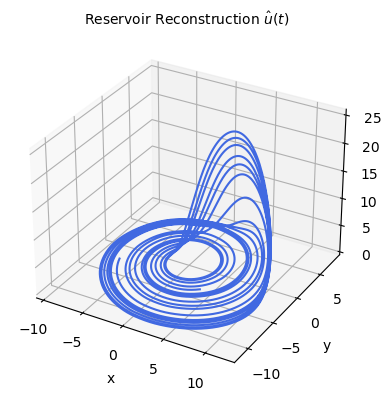

In [4]:
p1 = m.plot3D(cols=2, rows=2, figsize=(10, 15))

p1.plot3D(rc1.uPrediction[:, 70000:80000], plotNum=1, title = "Reservoir Reconstruction " + r'$ \hat u(t)$')

In [5]:
#Saving intial conditions
mu = 0
T = 5000; N_s = 100
rngA = np.random.default_rng(seed=4090)
indexA = rngA.choice(T, N_s, replace=False, shuffle=True)

IC_A = r_ts[:, indexA]

RS_stats_df = pd.DataFrame(IC_A)
RS_stats_df.to_csv("OutputData\\ReservoirSurrogates_IC\\A_Uncoupled.csv")
            

In [6]:
class genSurrogates():
    def __init__(self, file = "OutputData\\ReservoirSurrogates_IC\\"):
        self.file = file

    def load_ic(self, mu):
        IC_A_csv = np.array(pd.read_csv(self.file+"A_"+str(mu)+".csv"))
        #IC_B_csv = np.array(pd.read_csv(self.file+"B_"+str(mu)+".csv"))

        return np.array(IC_A_csv)#,np.array(IC_B_csv)
    

    def Rossler_params(self, mu = 0, nu = 0.02, a = 0.2, b = 0.2, c =5.7, T = 50, dt = 0.01, t0 = 0):
        self.Ry = s.yCoupledRossler(a = a, b = b, c = c, nu1 = nu, mu1 = mu, nu2 = nu, mu2 = mu)
        self.T = T; self.dt = dt; self.t0 = t0

    
    def gen_Coupled_Rossler(self, ic_A, ic_B):
         R = self.Ry.solve(t0 = self.t0, tFinal = self.T, x0_1 = ic_A, x0_2 = ic_B, dt = self.dt)
         return R
    
    def set_reservoir(self, rc1, T = 50, tListen = 700): 
        self.rc = rc1
        self.T = T
        self.tListen = tListen

    def reservoir_prediction(self, rIntial):
        self.rc.rListenFinal = rIntial
        U = self.rc.Predicting(t0 = self.tListen, tFinal = self.tListen+self.T, return_u_only=True)
        return U

In [13]:
#### Generating Surrogates 

In [17]:
#Setting time for real trajectories
tStart = 700
tEnd = 800
dt = 0.01
iStart = int(tStart/dt) #Discarding beginning of time series 
iEnd = int(tEnd/dt) 

In [18]:
gS = genSurrogates()
r = rc.Reservoir(Nodes = 100, InDim=3, seed=12)
r.Weighted_Erdos_R(SpecRadius=rho, p=0.04)
r.set_rdot(sigma = sigma, gamma = 1)
r.Set_W_in_Matrix() #Error from normalising specral radius

rc1 = rc.RC(SparseReservoir=r, U=A0, dt = 0.01)

rc1.Listening(time=700)
rc1.Training(t0 = 500, tEnd = 700)

gS.set_reservoir(rc1 = rc1, T = 100)

params = []
for w in range(0, N_s): 
        params.append(IC_A[:, w])


with mp.Pool(processes=6) as pool:
        results = pool.map_async(gS.reservoir_prediction, params)
        Surrogates = results.get()

params = []
for j in range(0, N_s):
        a = [Surrogates[j], B0[:, iStart:iEnd]]
        params.append(a)

with mp.Pool(processes=6) as pool:
        results = pool.starmap_async(m.PSstat1, params)
        S_stats = results.get()

RS_stats_df = pd.DataFrame(S_stats)
RS_stats_df.to_csv("OutputData\\ReservoirSurrogates_IC\\S_dist_Uncoupled.csv")




c:\Users\jackr\anaconda3\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[1.5179179e-05]
not reaching the requested tolerance 1.4901161193847656e-06.
Use iteration 21 instead with accuracy 
1.5179179046911312e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
c:\Users\jackr\anaconda3\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[1.5179179e-05]
not reaching the requested tolerance 1.4901161193847656e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


In [23]:
x = m.PSstat1(A0[:, 80000:90000], B0[:, 80000:90000])
x

0.38975954212611985

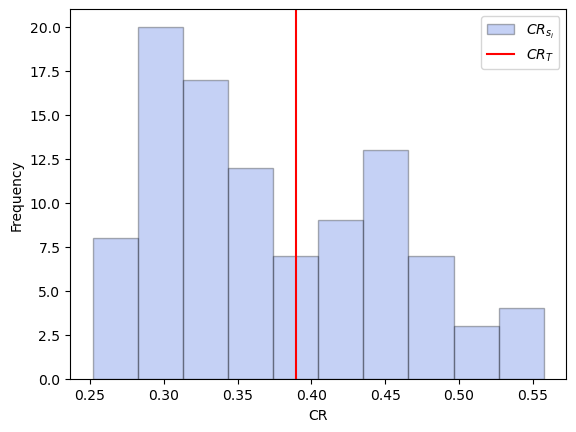

In [33]:
# Create histogram with no fill

plt.hist(S_stats, edgecolor='black', facecolor='royalblue', alpha=0.3, label=r'$CR_{s_i}$')
plt.axvline(x, color='r',  label=r'$CR_T$')
# Labels and title
plt.xlabel('CR')
plt.ylabel('Frequency')
#plt.title('Distribution of CR values')
plt.legend()

plt.savefig("OutputGraphics\\HT_Uncoupled_rossler_reservoir.svg")

In [32]:
#S_stat_1 = np.array(pd.read_csv("OutputData\\IdealSurrogate_IC\\S_dist_"+str(mu_pts[i])+".csv"))[:, 1]
a = np.array(np.where(S_stats < x)).shape[1]
p = a / len(S_stats)
p

0.61